## Automated Hyperparameter Selection 

This tutorial demonstrates how to automatically select optimal Gaussian Process hyperparameters for your surrogate model by testing multiple configurations and choosing the one with the best test set performance.

### Why This Matters

GP surrogate model performance is highly sensitive to:
- **Kernel choice** (ExpSquared, Matern32, Matern52, etc.)
- **Data scaling** (no scaling, MinMax, StandardScaler)
- **Other hyperparameters** (white noise, amplitude, length scales)

Rather than manually tuning these, we can systematically test combinations and select the best configuration based on test set mean squared error (MSE).

### Step 1: Import Required Libraries

Import `alabi` and its submodules along with standard scientific computing libraries.

In [28]:
import alabi
import alabi.utility as ut
import alabi.benchmarks as bm
from alabi.core import SurrogateModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from itertools import product

np.random.seed(101)

### Step 2: Define Problem and Base Configuration

Set up the benchmark problem (eggbox function) and define a base configuration for GP hyperparameters. These settings will be partially overridden when we test different combinations.

**Key parameters:**
- `ninit`: Number of initial training points
- `niter`: Number of active learning iterations
- `ncore`: Number of CPU cores for parallel evaluation (use 1 if experiencing multiprocessing issues)
- `white_noise`: Log-scale white noise parameter (increase if you see positive definiteness errors)

In [44]:
ninit = 50
niter = 100
basedir = "demo"
kernel = "ExpSquaredKernel"
benchmark = "rosenbrock"
savedir = f"{basedir}/{benchmark}/{kernel}/{ninit}_{niter}"

gp_kwargs = {"kernel": kernel, 
             "fit_amp": True, 
             "fit_mean": True, 
             "fit_white_noise": False, 
             "white_noise": -12,
             "gp_opt_method": "l-bfgs-b",
             "hyperopt_method": "cv",
             "cv_folds": 8,
             "gp_amp_rng": [-1,1],
             "gp_scale_rng": [-2,2],
             "theta_scaler": alabi.no_scaler,
             "y_scaler": alabi.no_scaler}
    
sm = SurrogateModel(lnlike_fn=bm.eggbox["fn"], 
                    bounds=bm.eggbox["bounds"], 
                    savedir=savedir,
                    ncore=8, 
                    pool_method="forkserver",
                    verbose=True)

sm.init_samples(ntrain=ninit, ntest=1000, sampler="sobol")

100%|██████████| 1000/1000 [00:01<00:00, 745.40it/s]


### Step 3: Create Hyperparameter Grid

Generate all combinations of the hyperparameters we want to test:
- **Kernels**: Different covariance functions capture different smoothness assumptions
- **Theta scaler**: How to scale input parameters
- **Y scaler**: How to scale output values

The `dict_to_combinations` function creates a Cartesian product of all options.

In [45]:
def dict_to_combinations(options_dict):
    keys = options_dict.keys()
    values = options_dict.values()
    return [dict(zip(keys, combo)) for combo in product(*values)]

def combinations_to_dict(combinations):
    result = {key: [] for key in combinations[0].keys()}
    for combo in combinations:
        for key, value in combo.items():
            result[key].append(value)
    return result

gp_kwarg_options = {"kernel": ["ExpSquaredKernel", "Matern32Kernel", "Matern52Kernel"],
                    "theta_scaler": [ut.no_scaler, preprocessing.MinMaxScaler(), preprocessing.StandardScaler()],
                    "y_scaler": [ut.no_scaler, preprocessing.MinMaxScaler(), preprocessing.StandardScaler()]}

variable_settings = dict_to_combinations(gp_kwarg_options)
print(len(variable_settings), "combinations to test")

# get a list of dictionaries with all combinations of settings, where each dictionary is a copy of the original gp_kwargs with the variable settings updated
setting_combos = []
for settings in variable_settings:
    new_settings = gp_kwargs.copy()
    for key in settings.keys():
        new_settings[key] = settings[key]
    setting_combos.append(new_settings)

27 combinations to test


### Step 4: Test All Hyperparameter Combinations

Loop through all combinations and fit a GP for each. The `init_gp` method returns the test set MSE, which we use to evaluate performance.

**Note:** This can take several minutes depending on the number of combinations and problem dimensionality. Use `try/except` to handle configurations that fail to converge.

In [46]:
for ii in range(len(setting_combos)):
    try:
        test_mse = sm.init_gp(**setting_combos[ii], overwrite=True)
    except:
        test_mse = np.nan
    setting_combos[ii]["test_mse"] = test_mse

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 390.42candidate/s]

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 488.01candidate/s]


Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 526.20candidate/s]


Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 409.93candidate/s]


Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 518.30candidate/s]


Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 393.58candidate/s]


Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 489.17candidate/s]


Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 402.87candidate/s]

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 493.51candidate/s]


Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 432.37candidate/s]


Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 511.54candidate/s]


Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 391.12candidate/s]


Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 410.56candidate/s]


Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 462.23candidate/s]


Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 451.44candidate/s]


Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 551.69candidate/s]


Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 508.10candidate/s]


Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 416.98candidate/s]


Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 558.47candidate/s]


Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 412.66candidate/s]


Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 394.23candidate/s]


Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 596.50candidate/s]


Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 530.68candidate/s]


Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 470.37candidate/s]


Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 457.15candidate/s]


Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 482.89candidate/s]


Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 520.55candidate/s]


### Step 5: Analyze Results

Convert results to a pandas DataFrame and inspect the top-performing configurations. Lower test MSE indicates better generalization performance.

In [47]:
results = pd.DataFrame(data=combinations_to_dict(setting_combos))
top_fits = results.sort_values("test_mse").head(5)
top_fits

,kernel,fit_amp,fit_mean,fit_white_noise,white_noise,gp_opt_method,hyperopt_method,cv_folds,gp_amp_rng,gp_scale_rng,theta_scaler,y_scaler,test_mse
15,Matern32Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",StandardScaler(),no_scaler,2773.298860
26,Matern52Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",StandardScaler(),StandardScaler(),2812.526356
17,Matern32Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",StandardScaler(),StandardScaler(),2862.467945
24,Matern52Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",StandardScaler(),no_scaler,2915.960206
13,Matern32Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",MinMaxScaler(),MinMaxScaler(),2935.585781


### Step 6: Extract Best Configuration

Identify the hyperparameter configuration with the lowest test MSE. This will be used for active learning.

In [48]:
best_gp_results = results[results["test_mse"] == results["test_mse"].min()]
best_gp_results

,kernel,fit_amp,fit_mean,fit_white_noise,white_noise,gp_opt_method,hyperopt_method,cv_folds,gp_amp_rng,gp_scale_rng,theta_scaler,y_scaler,test_mse
15,Matern32Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",StandardScaler(),no_scaler,2773.29886


### Step 7: Run Active Learning

Use the optimal GP configuration for active learning. The BAPE (Bayesian Active Posterior Estimation) algorithm iteratively selects new training points to improve the surrogate model.

**Key active learning parameters:**
- `algorithm`: Acquisition function ("bape", "agp", or "jones")
- `gp_opt_freq`: How often to reoptimize GP hyperparameters during training
- `obj_opt_method`: Optimization method for acquisition function
- `nopt`: Number of optimization restarts for acquisition function

In [49]:
best_gp_kwargs = best_gp_results[gp_kwargs.keys()].to_dict(orient="records")[0]

al_kwargs = {"algorithm": "bape", 
             "gp_opt_freq": 20, 
             "obj_opt_method": "nelder-mead", 
             "nopt": 6}

sm.init_gp(**best_gp_kwargs, overwrite=True)
sm.active_train(niter=200, **al_kwargs)

Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 426.13candidate/s]


Running 200 active learning iterations using bape...


 10%|▉         | 19/200 [00:04<00:42,  4.30it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 10%|█         | 21/200 [00:06<01:43,  1.73it/s]

Train MSE: 1.177939781797706e-27
Test MSE: 2037.4196464547156


 20%|█▉        | 39/200 [00:09<00:31,  5.19it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 20%|██        | 40/200 [00:11<01:55,  1.38it/s]

Train MSE: 1.1071783325192976e-27
Test MSE: 1402.7181920233404


 30%|██▉       | 59/200 [00:15<00:27,  5.15it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 30%|███       | 60/200 [00:17<01:39,  1.41it/s]

Train MSE: 6.571471306016613e-28
Test MSE: 797.6722072941037


 40%|███▉      | 79/200 [00:20<00:24,  4.99it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 40%|████      | 80/200 [00:22<01:29,  1.34it/s]

Train MSE: 1.4333826411295631e-27
Test MSE: 362.8145885540324


 50%|████▉     | 99/200 [00:26<00:19,  5.14it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 50%|█████     | 100/200 [00:28<01:16,  1.32it/s]

Train MSE: 3.972567768878909e-27
Test MSE: 288.4807145584818


 60%|█████▉    | 119/200 [00:32<00:15,  5.31it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 60%|██████    | 121/200 [00:34<00:46,  1.70it/s]

Train MSE: 5.423056775449708e-27
Test MSE: 210.31139633096768


 70%|██████▉   | 139/200 [00:38<00:11,  5.41it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 70%|███████   | 140/200 [00:40<00:46,  1.28it/s]

Train MSE: 2.9376160819102945e-26
Test MSE: 157.83050691150333


 80%|███████▉  | 159/200 [00:44<00:08,  4.68it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 80%|████████  | 160/200 [00:46<00:32,  1.23it/s]

Train MSE: 3.0896907496657e-26
Test MSE: 100.02936112302628


 90%|████████▉ | 179/200 [00:50<00:04,  5.21it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 90%|█████████ | 180/200 [00:52<00:15,  1.27it/s]

Train MSE: 1.121264493891098e-25
Test MSE: 77.86369267622483


100%|█████████▉| 199/200 [00:57<00:00,  3.95it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


100%|██████████| 200/200 [00:59<00:00,  3.35it/s]

Train MSE: 2.2912292626036497e-25
Test MSE: 51.7012568770836
Caching model to demo/rosenbrock/ExpSquaredKernel/50_100/surrogate_model...


### Step 8: Visualize Training Progress

Plot the test set MSE over active learning iterations. A decreasing trend indicates the surrogate model is improving. We can also highlight which iterations the GP hyperparameters are re-optimized (vertical gray lines).

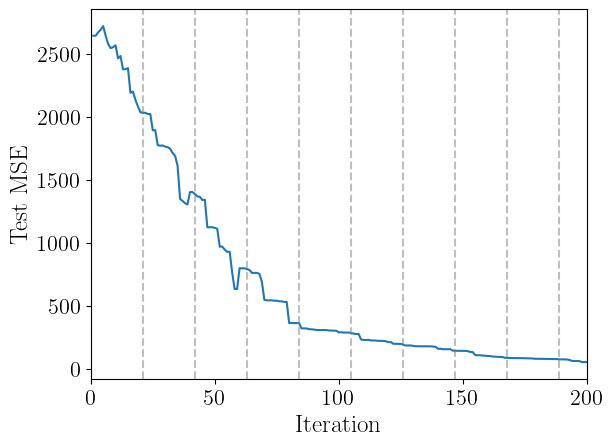

In [50]:
plt.plot(sm.training_results["iteration"], sm.training_results["test_mse"])
for ii in range(0, sm.nactive, sm.gp_opt_freq+1):
    plt.axvline(ii, color="gray", linestyle="--", alpha=0.5)
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Test MSE", fontsize=18)
plt.xlim(0, sm.nactive)
plt.show()

How do the other top initial fits perform during active learning?

In [51]:
al_kwargs = {"algorithm": "bape", 
             "gp_opt_freq": 20, 
             "obj_opt_method": "nelder-mead", 
             "nopt": 6}

mse_results = {}
for idx in top_fits.index:
    gp_kwargs_idx = top_fits[top_fits.index == idx][gp_kwargs.keys()].to_dict(orient="records")[0]
    sm.init_gp(**gp_kwargs_idx, overwrite=True)
    sm.active_train(niter=200, **al_kwargs)
    mse_results[idx] = sm.training_results["test_mse"]

Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 405.96candidate/s]


Running 200 active learning iterations using bape...


 10%|▉         | 19/200 [00:01<00:11, 16.28it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 340.21candidate/s]


Train MSE: 2.0530726286339693e-26
Test MSE: 2477.800374502593


 20%|█▉        | 39/200 [00:07<00:35,  4.55it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 20%|██        | 40/200 [00:09<02:02,  1.31it/s]

Train MSE: 5.1599512330922456e-27
Test MSE: 1063.441129766629


 30%|██▉       | 59/200 [00:13<00:31,  4.47it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 30%|███       | 60/200 [00:15<01:47,  1.31it/s]

Train MSE: 1.461269894683444e-26
Test MSE: 598.25492096148


 40%|███▉      | 79/200 [00:19<00:27,  4.45it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 40%|████      | 80/200 [00:21<01:34,  1.27it/s]

Train MSE: 1.3057177916451815e-26
Test MSE: 425.99777931441054


 50%|████▉     | 99/200 [00:25<00:21,  4.68it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 50%|█████     | 100/200 [00:27<01:15,  1.32it/s]

Train MSE: 7.500930920256261e-26
Test MSE: 303.62169555801796


 60%|█████▉    | 119/200 [00:32<00:19,  4.16it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 60%|██████    | 121/200 [00:34<00:48,  1.63it/s]

Train MSE: 3.035600162185263e-26
Test MSE: 250.85439126746286


 70%|██████▉   | 139/200 [00:38<00:11,  5.13it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 70%|███████   | 141/200 [00:40<00:35,  1.68it/s]

Train MSE: 5.978931718420186e-26
Test MSE: 181.4194648412912


 80%|███████▉  | 159/200 [00:44<00:10,  4.04it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 80%|████████  | 160/200 [00:46<00:32,  1.22it/s]

Train MSE: 3.9844685291906736e-25
Test MSE: 114.0325882697041


 90%|████████▉ | 179/200 [00:51<00:05,  4.06it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 90%|█████████ | 180/200 [00:53<00:17,  1.16it/s]

Train MSE: 1.434691991041946e-24
Test MSE: 72.91217003740606


100%|█████████▉| 199/200 [00:58<00:00,  3.88it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


100%|██████████| 200/200 [01:00<00:00,  3.29it/s]

Train MSE: 1.9717623470536645e-24
Test MSE: 59.15127338069432
Caching model to demo/rosenbrock/ExpSquaredKernel/50_100/surrogate_model...
Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 401.21candidate/s]


Running 200 active learning iterations using bape...


  9%|▉         | 18/200 [00:01<00:12, 14.56it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 11%|█         | 22/200 [00:03<00:46,  3.84it/s]

Train MSE: 2.244276764456224e-13
Test MSE: 1828.6952948027415


 19%|█▉        | 38/200 [00:04<00:12, 13.16it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 21%|██        | 42/200 [00:06<00:41,  3.81it/s]

Train MSE: 2.2121827115517646e-14
Test MSE: 1701.6461388863795


 29%|██▉       | 58/200 [00:07<00:10, 13.81it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 31%|███       | 62/200 [00:09<00:37,  3.71it/s]

Train MSE: 7.867815323740049e-14
Test MSE: 1045.8021624249257


 39%|███▉      | 78/200 [00:10<00:09, 13.34it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 41%|████      | 82/200 [00:12<00:31,  3.72it/s]

Train MSE: 3.5082179316710085e-13
Test MSE: 609.2425827523684


 49%|████▉     | 98/200 [00:13<00:07, 13.48it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 51%|█████     | 102/200 [00:16<00:27,  3.52it/s]

Train MSE: 1.3307632235376274e-12
Test MSE: 382.6031052567994


 59%|█████▉    | 118/200 [00:17<00:06, 13.36it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 61%|██████    | 122/200 [00:19<00:22,  3.54it/s]

Train MSE: 5.620076753185335e-13
Test MSE: 247.31078931836382


 69%|██████▉   | 138/200 [00:20<00:04, 13.28it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 71%|███████   | 142/200 [00:22<00:17,  3.34it/s]

Train MSE: 1.4967138562322827e-05
Test MSE: 213.6385572437276


 79%|███████▉  | 158/200 [00:23<00:03, 12.99it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 81%|████████  | 162/200 [00:26<00:11,  3.27it/s]

Train MSE: 0.00031184047679421443
Test MSE: 151.49420444936445


 89%|████████▉ | 178/200 [00:27<00:01, 12.66it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 91%|█████████ | 182/200 [00:29<00:05,  3.12it/s]

Train MSE: 2.92105991847098e-11
Test MSE: 127.54237820148164


 99%|█████████▉| 198/200 [00:31<00:00, 12.18it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


100%|██████████| 200/200 [00:33<00:00,  5.94it/s]

Train MSE: 8.971148500606388e-07
Test MSE: 88.45691068831374
Caching model to demo/rosenbrock/ExpSquaredKernel/50_100/surrogate_model...
Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 337.30candidate/s]


Running 200 active learning iterations using bape...


  9%|▉         | 18/200 [00:01<00:11, 15.75it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 11%|█         | 22/200 [00:03<00:47,  3.74it/s]

Train MSE: 1.1740282706697076e-07
Test MSE: 1844.7511654725322


 19%|█▉        | 38/200 [00:04<00:11, 13.59it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 21%|██        | 42/200 [00:06<00:42,  3.73it/s]

Train MSE: 1.3385628513889e-08
Test MSE: 1409.42236063091


 29%|██▉       | 58/200 [00:07<00:10, 13.66it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 31%|███       | 62/200 [00:09<00:38,  3.58it/s]

Train MSE: 5.777934324158119e-09
Test MSE: 986.5818536326015


 39%|███▉      | 78/200 [00:10<00:08, 13.68it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 41%|████      | 82/200 [00:12<00:30,  3.82it/s]

Train MSE: 4.5879959682760145e-09
Test MSE: 543.9744968396296


 49%|████▉     | 98/200 [00:13<00:07, 13.36it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 51%|█████     | 102/200 [00:15<00:26,  3.72it/s]

Train MSE: 1.2589179746368469e-11
Test MSE: 407.7327679081473


 59%|█████▉    | 118/200 [00:16<00:06, 13.40it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 61%|██████    | 122/200 [00:19<00:21,  3.57it/s]

Train MSE: 2.250819653658766e-11
Test MSE: 291.2191997960778


 69%|██████▉   | 138/200 [00:20<00:05, 12.29it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 71%|███████   | 142/200 [00:22<00:17,  3.28it/s]

Train MSE: 0.008453317873131506
Test MSE: 240.87253685522143


 79%|███████▉  | 158/200 [00:23<00:03, 12.62it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 81%|████████  | 162/200 [00:26<00:12,  2.98it/s]

Train MSE: 2.3306807401158976e-09
Test MSE: 203.97458297128549


 89%|████████▉ | 178/200 [00:27<00:01, 11.78it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 91%|█████████ | 182/200 [00:30<00:05,  3.20it/s]

Train MSE: 9.117656947080212e-13
Test MSE: 168.17128400317935


 99%|█████████▉| 198/200 [00:31<00:00, 12.00it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


100%|██████████| 200/200 [00:33<00:00,  5.91it/s]

Train MSE: 9.545821422365206e-10
Test MSE: 126.47864964877573
Caching model to demo/rosenbrock/ExpSquaredKernel/50_100/surrogate_model...
Initialized GP with Matérn-5/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 439.35candidate/s]


Running 200 active learning iterations using bape...


  9%|▉         | 18/200 [00:01<00:12, 15.13it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 10%|█         | 20/200 [00:03<01:00,  2.95it/s]

Train MSE: 3.582961434075181e-24
Test MSE: 2548.0037345458495


 20%|█▉        | 39/200 [00:06<00:32,  4.97it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 20%|██        | 40/200 [00:08<01:58,  1.35it/s]

Train MSE: 4.133077845084301e-27
Test MSE: 1168.938084077836


 30%|██▉       | 59/200 [00:12<00:27,  5.13it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 30%|███       | 60/200 [00:14<01:43,  1.35it/s]

Train MSE: 1.327232476481794e-27
Test MSE: 734.9205235212905


 40%|███▉      | 79/200 [00:19<00:29,  4.06it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 40%|████      | 80/200 [00:21<01:32,  1.29it/s]

Train MSE: 9.315817718976175e-28
Test MSE: 553.2034961973445


 50%|████▉     | 99/200 [00:25<00:21,  4.74it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 50%|█████     | 101/200 [00:27<00:59,  1.67it/s]

Train MSE: 2.4458099885266446e-27
Test MSE: 377.1965552264245


 60%|█████▉    | 119/200 [00:31<00:19,  4.22it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 60%|██████    | 120/200 [00:33<01:03,  1.26it/s]

Train MSE: 1.662627025679918e-27
Test MSE: 314.96622462567257


 70%|██████▉   | 139/200 [00:37<00:11,  5.21it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 70%|███████   | 140/200 [00:39<00:45,  1.31it/s]

Train MSE: 7.283100699847413e-27
Test MSE: 124.92334068201727


 80%|███████▉  | 159/200 [00:43<00:09,  4.21it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 80%|████████  | 160/200 [00:45<00:32,  1.23it/s]

Train MSE: 2.502267777437181e-26
Test MSE: 111.80423521240577


 90%|████████▉ | 179/200 [00:50<00:04,  4.47it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 90%|█████████ | 180/200 [00:52<00:16,  1.20it/s]

Train MSE: 1.5405793108068365e-25
Test MSE: 89.07261945891817


100%|█████████▉| 199/200 [00:57<00:00,  3.68it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


100%|██████████| 200/200 [00:59<00:00,  3.34it/s]

Train MSE: 1.445994075315376e-25
Test MSE: 66.35134262096383
Caching model to demo/rosenbrock/ExpSquaredKernel/50_100/surrogate_model...
Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1

Optimizing GP hyperparameters using 8-fold cross-validation...


Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


Stage 3 candidates: 100%|██████████| 25/25 [00:00<00:00, 463.05candidate/s]


Running 200 active learning iterations using bape...


  9%|▉         | 18/200 [00:01<00:09, 18.61it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 11%|█         | 22/200 [00:03<00:42,  4.23it/s]

Train MSE: 0.004265753697276331
Test MSE: 2398.304079962393


 19%|█▉        | 38/200 [00:03<00:11, 14.65it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 21%|██        | 42/200 [00:05<00:38,  4.09it/s]

Train MSE: 0.00038325424877956116
Test MSE: 1635.1604450229624


 30%|██▉       | 59/200 [00:06<00:08, 16.32it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 30%|███       | 61/200 [00:08<00:42,  3.28it/s]

Train MSE: 0.005403056785029362
Test MSE: 1122.5917937593767


 39%|███▉      | 78/200 [00:09<00:08, 13.81it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 41%|████      | 82/200 [00:11<00:29,  4.03it/s]

Train MSE: 0.0017742142507110026
Test MSE: 807.055886357036


 49%|████▉     | 98/200 [00:12<00:07, 14.26it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 51%|█████     | 102/200 [00:14<00:26,  3.66it/s]

Train MSE: 0.0003605277372091531
Test MSE: 544.617905521699


 59%|█████▉    | 118/200 [00:15<00:05, 14.15it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 61%|██████    | 122/200 [00:18<00:21,  3.57it/s]

Train MSE: 0.0012391636182509473
Test MSE: 398.1496625286267


 69%|██████▉   | 138/200 [00:18<00:04, 14.28it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 71%|███████   | 142/200 [00:21<00:16,  3.48it/s]

Train MSE: 0.0012629377283959564
Test MSE: 348.75280972877226


 79%|███████▉  | 158/200 [00:22<00:02, 14.13it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 81%|████████  | 162/200 [00:24<00:10,  3.49it/s]

Train MSE: 0.003158006250406481
Test MSE: 316.53295380564043


 89%|████████▉ | 178/200 [00:25<00:01, 13.78it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


 91%|█████████ | 182/200 [00:28<00:05,  3.11it/s]

Train MSE: 0.38382822096467906
Test MSE: 271.7672093646412


 99%|█████████▉| 198/200 [00:29<00:00, 13.01it/s]


Optimizing GP hyperparameters using 8-fold cross-validation...
Evaluating 100 hyperparameter candidates using 8-fold CV...
Using multiprocessing pool with 8 processes


100%|██████████| 200/200 [00:31<00:00,  6.32it/s]

Train MSE: 0.003438228785292073
Test MSE: 200.96902359044475
Caching model to demo/rosenbrock/ExpSquaredKernel/50_100/surrogate_model...


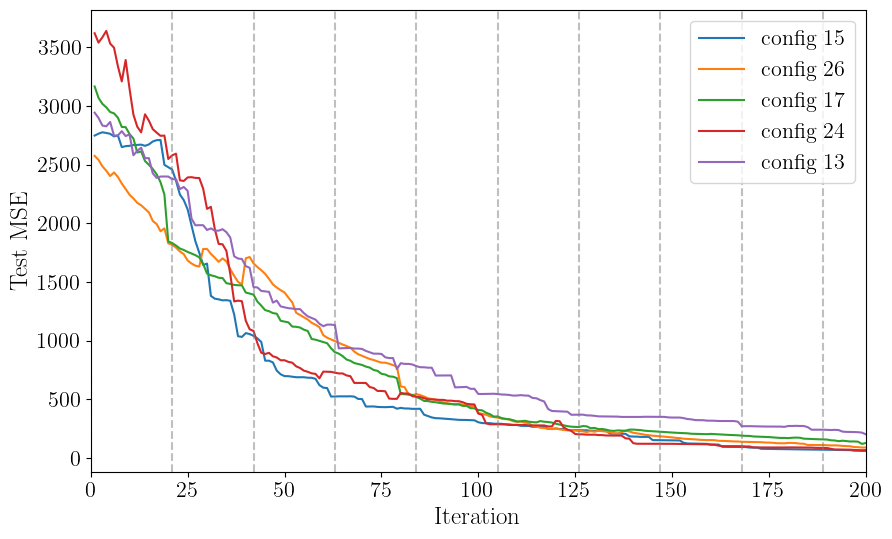

,kernel,fit_amp,fit_mean,fit_white_noise,white_noise,gp_opt_method,hyperopt_method,cv_folds,gp_amp_rng,gp_scale_rng,theta_scaler,y_scaler,test_mse
15,Matern32Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",StandardScaler(),no_scaler,2773.298860
26,Matern52Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",StandardScaler(),StandardScaler(),2812.526356
17,Matern32Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",StandardScaler(),StandardScaler(),2862.467945
24,Matern52Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",StandardScaler(),no_scaler,2915.960206
13,Matern32Kernel,True,True,False,-12,l-bfgs-b,cv,8,"[-1, 1]","[-2, 2]",MinMaxScaler(),MinMaxScaler(),2935.585781


In [52]:
plt.figure(figsize=(10,6))
for idx in top_fits.index:
    plt.plot(sm.training_results["iteration"], mse_results[idx], label=f"config {idx}")
for ii in range(0, sm.nactive, sm.gp_opt_freq+1):
    plt.axvline(ii, color="gray", linestyle="--", alpha=0.5)
plt.legend(loc="upper right", fontsize=16)
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Test MSE", fontsize=18)
plt.xlim(0, sm.nactive)
plt.show()

top_fits

### Next Steps

Now that you have an optimized surrogate model, you can:

1. **Run posterior sampling** with `sm.run_emcee()` or `sm.run_dynesty()`
2. **Visualize the surrogate** using `alabi.visualization` tools
3. **Test on new problems** by changing the benchmark function
4. **Expand the hyperparameter grid** to include more options like:
   - Different `white_noise` values
   - Different `cv_folds` settings
   - Different data scaling functions for `theta_scaler` or `y_scaler`